## KMeans Clustering -- EDA, JVA & Kinect(MoveDiff)

The clustering analysis below explores how motor sensors used in the MMLA study predict qualitative, collaborative outcomes. Measures used are as follows:
1. EDA: Directional Agreement, Signal Matching, Pearsons' Correlations, Instantaneous Directional Matching
2. JVA: number of jva100 counts per second
3. MoveDiff: difference in total movements between dyads

Clustering analysis was performed by combining each EDA measure with JVA and Kinect, the resulting analyses were:

1. DA+JVA+MoveDiff
2. SM+JVA+MoveDiff
3. PC+JVA+MoveDiff
4. IDM+JVA+MoveDiff

_Please see "KMeans Clustering with EDA + JVA + Kinect(MoveDiff) 5-10 Clusters Demo" for K in [5, 10]_

In [1]:
#import packages for clustering
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import sys
sys.path.insert(0, '../src/')
import cluster
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
sessions = pd.read_csv('../data_master/sessions.csv') #read sessions data
dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']

In [4]:
#generate master file for clustering
master = []
directory = 'group_combinewKinect_bySecond/' #get directory path
for csv in os.listdir(directory):
    file = pd.read_csv(directory+csv, index_col='Unnamed: 0')
    file['session'] = int(csv[:-28])
    cols = ['session','second_x','DA','PC','IDM','SM','jva100',
            'movement_total_L','movement_total_R',
            'Head_Y_L','Head_Y_R','ShoulderLeft_X_L','ShoulderLeft_X_R',
            'ShoulderRight_X_L','ShoulderRight_X_R']
    fileNew = file.loc[:, cols]
    fileNew = fileNew.rename(columns = {'second_x': 'second'})
    cols_fillnan = ['DA','PC','IDM','SM','jva100',
                    'movement_total_L','movement_total_R',
                    'Head_Y_L','Head_Y_R','ShoulderLeft_X_L','ShoulderLeft_X_R',
                    'ShoulderRight_X_L','ShoulderRight_X_R']
    fileNew[cols_fillnan] = fileNew[cols_fillnan].fillna(fileNew[cols_fillnan].mean(skipna=True)) #fill nans with mean for clustering purposes
    #compute difference in movement and append to data frame
    fileNew['moveDiff'] = abs(fileNew['movement_total_L'] - fileNew['movement_total_R'])
    #compute vertical difference in head orientations
    fileNew['headDiff'] = abs(fileNew['Head_Y_L'] - fileNew['Head_Y_R'])
    #compute horizontal difference in shoulder orientations
    fileNew['shoulderDiff'] = abs(fileNew['ShoulderLeft_X_L'] - fileNew['ShoulderRight_X_R']) - abs(fileNew['ShoulderRight_X_R'] - fileNew['ShoulderLeft_X_R'])
    master.append(fileNew)

In [7]:
dfMaster = pd.concat(master, axis = 0) #concatenate data frames for master file
dfMaster = dfMaster.fillna(dfMaster.mean(skipna = True))

In [9]:
#aggregate data
dfMaster = dfMaster.groupby(['session','second']).agg({
    'DA': np.mean,
    'PC': np.mean,
    'IDM': np.mean,
    'SM': np.mean,
    'jva100': np.mean,
    'moveDiff': np.mean,
    'headDiff': np.mean,
    'shoulderDiff': np.mean
})

dfMaster = dfMaster.reset_index().reset_index()
dfMaster.head()

,index,session,second,DA,PC,IDM,SM,jva100,moveDiff,headDiff,shoulderDiff
0,0,2,1,0.233333,-0.447563,0.177397,0.208709,24.0,1.941329,0.047057,0.658437
1,1,2,2,0.232708,-0.445837,0.177548,0.207804,7.0,2.013969,0.040868,0.654975
2,2,2,3,0.233125,-0.442000,0.177468,0.206289,18.0,1.825878,0.048828,0.642805
3,3,2,4,0.234583,-0.439776,0.176532,0.205172,23.0,1.675585,0.037022,0.648898
4,4,2,5,0.234375,-0.438995,0.175948,0.204015,6.0,1.967405,0.042931,0.646596


In [10]:
scaleCols = ['DA','PC','IDM','SM','jva100','moveDiff', 'headDiff','shoulderDiff'] #scale columns for clustering
scaler = StandardScaler()
scaler.fit(dfMaster[scaleCols])
dfMaster_scaled = dfMaster.copy() #copy original master data frame
dfMaster_scaled = dfMaster_scaled.loc[:, scaleCols]
dfMaster_scaled[scaleCols] = scaler.transform(dfMaster_scaled[scaleCols]) #scale transform cluster columns
dfMaster_scaled['index'] = np.arange(len(dfMaster_scaled)) #reappend index column to dfMaster_scaled for merging
dfMaster_scaled = dfMaster_scaled.rename(columns = {'DA':'DA_scaled', 'SM':'SM_scaled', 
                                                    'PC':'PC_scaled','IDM': 'IDM_scaled',
                                                    'jva100':'jva100_scaled',
                                                    'moveDiff': 'moveDiff_scaled',
                                                    'headDiff': 'headDiff_scaled',
                                                    'shoulderDiff': 'shoulderDiff_scaled'})
dfMaster = dfMaster.merge(dfMaster_scaled, on = 'index', how = 'outer') #merge scaled data with original data

In [11]:
dfMaster.to_csv('EDA_JVA_Kinect_MasterScaled.csv') #save data to csv

**Optimal K by Distortion Rate**

In [3]:
dfMaster = pd.read_csv('../data_master/EDA_JVA_Kinect_MasterScaled.csv', index_col="Unnamed: 0")

PC completed
DA completed
SM completed
IDM completed


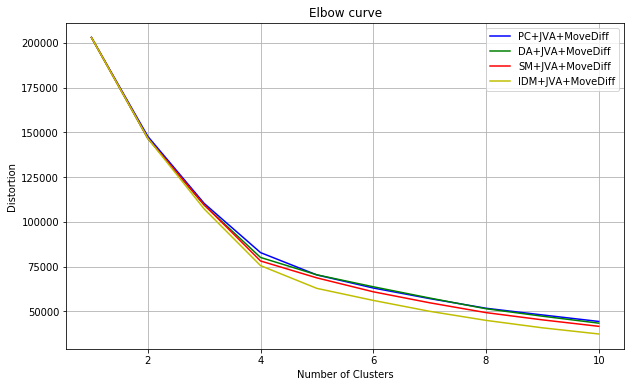

In [4]:
#find optimal number of clustering for KMeans
distortionPC = list() #cache list for distortion value
for n in range(1,11): #fit number of clusters in the range of 1 to 10
    kmeans_pc = KMeans(n_clusters=n, random_state=11)
    kmeans_pc.fit(dfMaster.loc[:, ['PC_scaled','jva100_scaled','moveDiff_scaled']]) 
    distortionPC.append(kmeans_pc.inertia_) #append distortion value to list
print('PC completed')

distortionDA = list()
for n in range(1,11):
    kmeans_da = KMeans(n_clusters=n, random_state=11)
    kmeans_da.fit(dfMaster.loc[:, ['DA_scaled','jva100_scaled','moveDiff_scaled']])
    distortionDA.append(kmeans_da.inertia_)
print('DA completed')

distortionSM = list()
for n in range(1,11):
    kmeans_sm = KMeans(n_clusters=n, random_state=11)
    kmeans_sm.fit(dfMaster.loc[:, ['SM_scaled','jva100_scaled','moveDiff_scaled']])
    distortionSM.append(kmeans_sm.inertia_)
print('SM completed')


distortionIDM = list()
for n in range(1,11):
    kmeans_idm = KMeans(n_clusters=n, random_state=11)
    kmeans_idm.fit(dfMaster.loc[:, ['IDM_scaled','jva100_scaled','moveDiff_scaled']])
    distortionIDM.append(kmeans_idm.inertia_)
print('IDM completed')


#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), distortionPC, c = 'b', label = 'PC+JVA+MoveDiff')
plt.plot(range(1, 11), distortionDA, c = 'g', label = 'DA+JVA+MoveDiff')
plt.plot(range(1, 11), distortionSM, c = 'r', label = 'SM+JVA+MoveDiff')
plt.plot(range(1, 11), distortionIDM, c = 'y', label = 'IDM+JVA+MoveDiff')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.legend()
plt.grid(True)
plt.title('Elbow curve')
plt.show()

**PC+JVA+Kinect**

In [5]:
#cluster by K=4 and K=3
dfMaster_pc4, centroids_pc4 = cluster.makeCluster(dfMaster, 4, 11, ['PC_scaled','jva100_scaled','moveDiff_scaled'])
dfMaster_pc3, centroids_pc3 = cluster.makeCluster(dfMaster, 3, 11, ['PC_scaled','jva100_scaled','moveDiff_scaled'])

In [16]:
dfMaster_pc4.to_csv('../data_visualization/PC_JVA_Kinect_4.csv')

----
K = 4

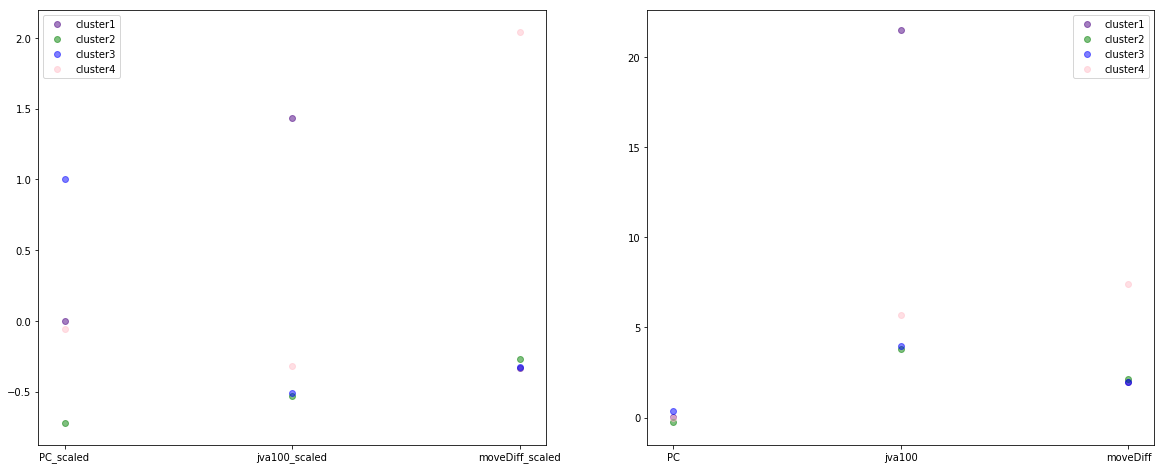

In [6]:
cluster.visualizeCluster(dfMaster_pc4, 4, ['PC_scaled','jva100_scaled','moveDiff_scaled'], ['PC','jva100','moveDiff'] )

In [7]:
timeCluster_pc4 = cluster.timeCluster(dfMaster_pc4, 4)

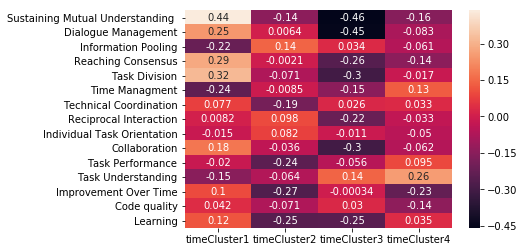

In [8]:
sessions_pc4 = sessions.merge(timeCluster_pc4, on = 'Session', how = 'outer') #merge data frames for correlation
time_pc4 = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_pc4 = sessions_pc4.corr()
ax = sns.heatmap(correlations_pc4.loc[dependent][time_pc4], annot=True)

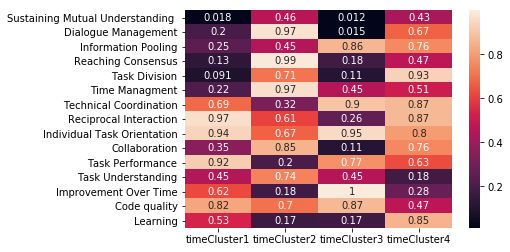

In [9]:
pvalues_pc4 = cluster.calculate_pvalues(sessions_pc4).astype(float)
ax = sns.heatmap(pvalues_pc4.loc[dependent][time_pc4], annot=True)

The heatmap above indicates that there is a significant correlation between 1) time spent in cluster 1 and sustaining mutual understanding (p = 0.0018), 2) time spent in cluster 3 and sustaining mutual understanding (p = 0.012), dialogue management (p = 0.015). 

Cluster 1:
1. Highest jva

Cluster 3:
1. Highest scaled PC

----
K = 3

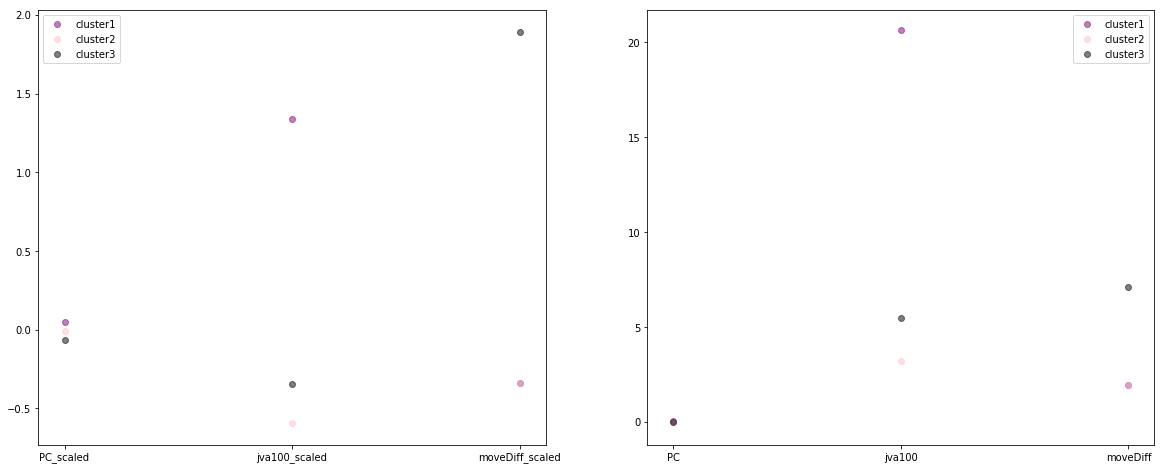

In [10]:
cluster.visualizeCluster(dfMaster_pc3, 3, ['PC_scaled','jva100_scaled','moveDiff_scaled'], ['PC','jva100','moveDiff'] )

In [11]:
timeCluster_pc3 = cluster.timeCluster(dfMaster_pc3, 3)

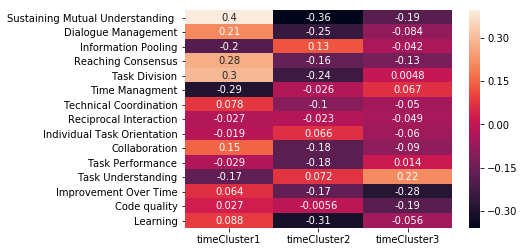

In [12]:
sessions_pc3 = sessions.merge(timeCluster_pc3, on = 'Session', how = 'outer') #merge data frames for correlation
time_pc3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_pc3 = sessions_pc3.corr()
ax = sns.heatmap(correlations_pc3.loc[dependent][time_pc3], annot=True)

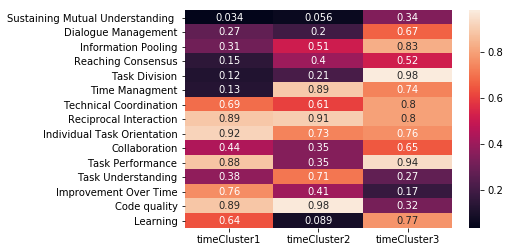

In [13]:
pvalues_pc3 = cluster.calculate_pvalues(sessions_pc3).astype(float)
ax = sns.heatmap(pvalues_pc3.loc[dependent][time_pc3], annot=True)

Significant correlations: 1) time spent in cluster 1 (highest jva and highest pc) and sustaining mutual understanding (p = 0.034).

**DA+JVA+Kinect**

In [14]:
#cluster by k = 4 and k = 3
dfMaster_da4, centroids_da4 = cluster.makeCluster(dfMaster, 4, 11, ['DA_scaled','jva100_scaled','moveDiff_scaled'])
dfMaster_da3, centroids_da3 = cluster.makeCluster(dfMaster, 3, 11, ['DA_scaled','jva100_scaled','moveDiff_scaled'])

In [26]:
dfMaster_da4.to_csv('../data_visualization/DA_JVA_Kinect_4.csv')

----
K = 4

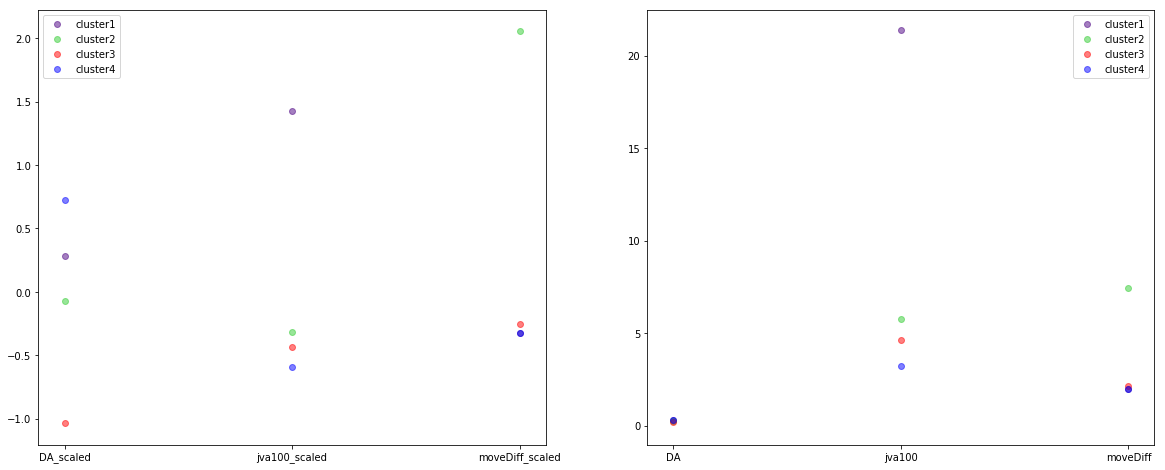

In [15]:
cluster.visualizeCluster(dfMaster_da4, 4, ['DA_scaled','jva100_scaled','moveDiff_scaled'], ['DA','jva100','moveDiff'] )

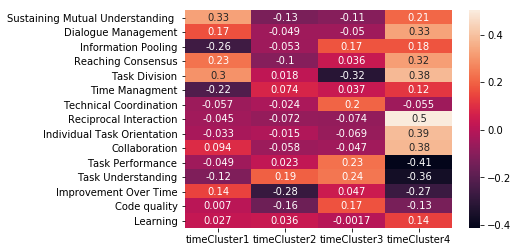

In [16]:
timeCluster_da4 = cluster.timeCluster(dfMaster_da4, 4)
sessions_da4 = sessions.merge(timeCluster_da4, on = 'Session', how = 'outer') #merge data frames for correlation
time_da4 = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_da4 = sessions_da4.corr()
ax = sns.heatmap(correlations_da4.loc[dependent][time_da4], annot=True)

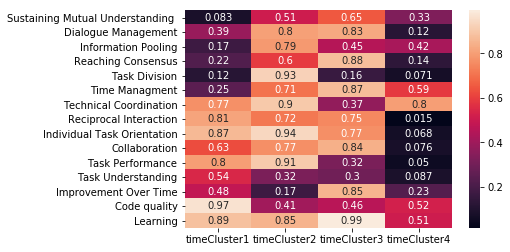

In [17]:
pvalues_da4 = cluster.calculate_pvalues(sessions_da4).astype(float)
ax = sns.heatmap(pvalues_da4.loc[dependent][time_da4], annot=True)

Significant correlations: 1) time spent in cluster 4 (Highest da, lowest jva) and reciprocal interaction(p = 0.015). 

----
K = 3

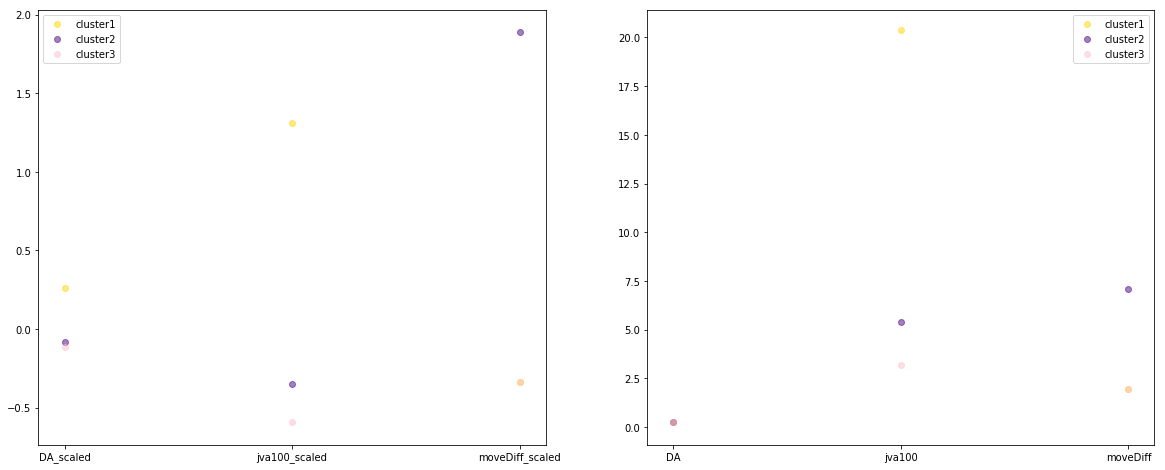

In [18]:
cluster.visualizeCluster(dfMaster_da3, 3, ['DA_scaled','jva100_scaled','moveDiff_scaled'], ['DA','jva100','moveDiff'] )

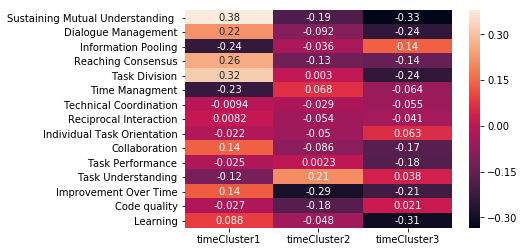

In [19]:
timeCluster_da3 = cluster.timeCluster(dfMaster_da3, 3)
sessions_da3 = sessions.merge(timeCluster_da3, on = 'Session', how = 'outer') #merge data frames for correlation
time_da3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_da3 = sessions_da3.corr()
ax = sns.heatmap(correlations_da3.loc[dependent][time_da3], annot=True)

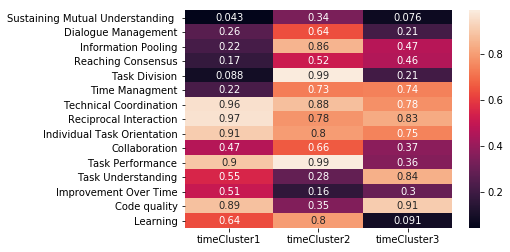

In [20]:
pvalues_da3 = cluster.calculate_pvalues(sessions_da3).astype(float)
ax = sns.heatmap(pvalues_da3.loc[dependent][time_da3], annot=True)

Significant correlations: 1) time spent in cluster 1(highest da, highest jva) and sustaining mutual understanding (p = 0.043).

**SM + JVA + Kinect**

In [21]:
dfMaster_sm4, centroids_sm4 = cluster.makeCluster(dfMaster, 4, 11, ['SM_scaled','jva100_scaled','moveDiff_scaled'])
dfMaster_sm3, centroids_sm3 = cluster.makeCluster(dfMaster, 3, 11, ['SM_scaled','jva100_scaled','moveDiff_scaled'])

In [34]:
dfMaster_sm4.to_csv('../data_visualization/SM_JVA_Kinect_4.csv')

----
K = 4

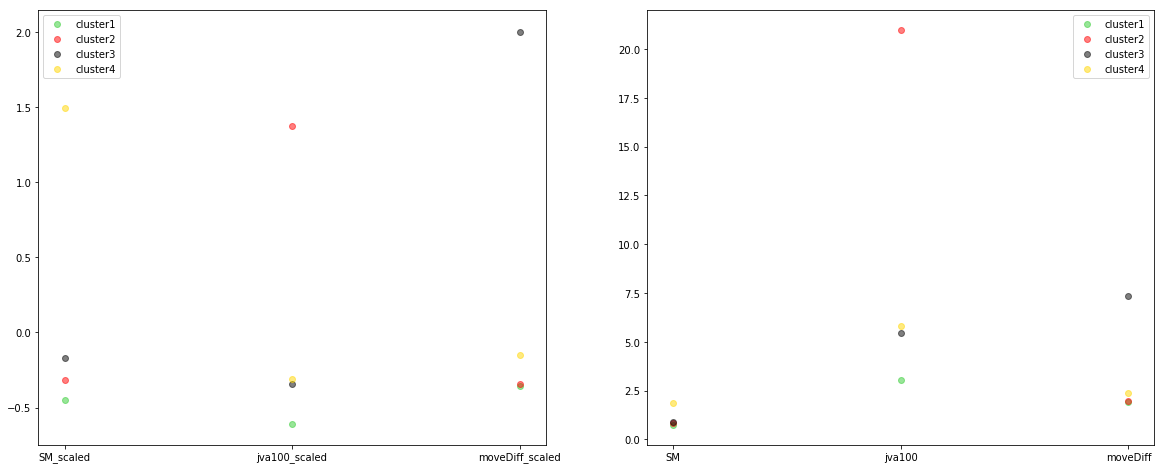

In [22]:
cluster.visualizeCluster(dfMaster_sm4, 4, ['SM_scaled','jva100_scaled','moveDiff_scaled'], ['SM','jva100','moveDiff'])

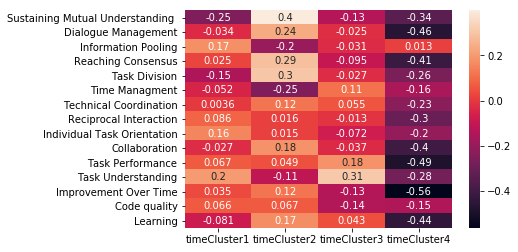

In [23]:
timeCluster_sm4 = cluster.timeCluster(dfMaster_sm4,4)
sessions_sm4 = sessions.merge(timeCluster_sm4, on = 'Session', how = 'outer') #merge data frames for correlation
time_sm4 = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_sm4 = sessions_sm4.corr()
ax = sns.heatmap(correlations_sm4.loc[dependent][time_sm4], annot=True)

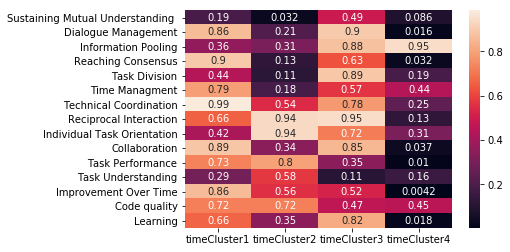

In [24]:
pvalues_sm4 = cluster.calculate_pvalues(sessions_sm4).astype(float)
ax = sns.heatmap(pvalues_sm4.loc[dependent][time_sm4], annot=True)

The above heatmap indicates that there is a significant correlation between 1) time spent in cluster 2 and sustaining mutual understanding (p = 0.032), 2) time spent in cluster 4 and diaglogue management (p = 0.016), reaching consensus (p = 0.032), collaboration(p = 0.037), task performance (p = 0.01), improvement over time (p = 0.0042), learning (p = 0.018) 

Cluster 2:
1. Highest JVA
2. Least movement difference

Cluster 4:
* Highest SM

----
K = 3

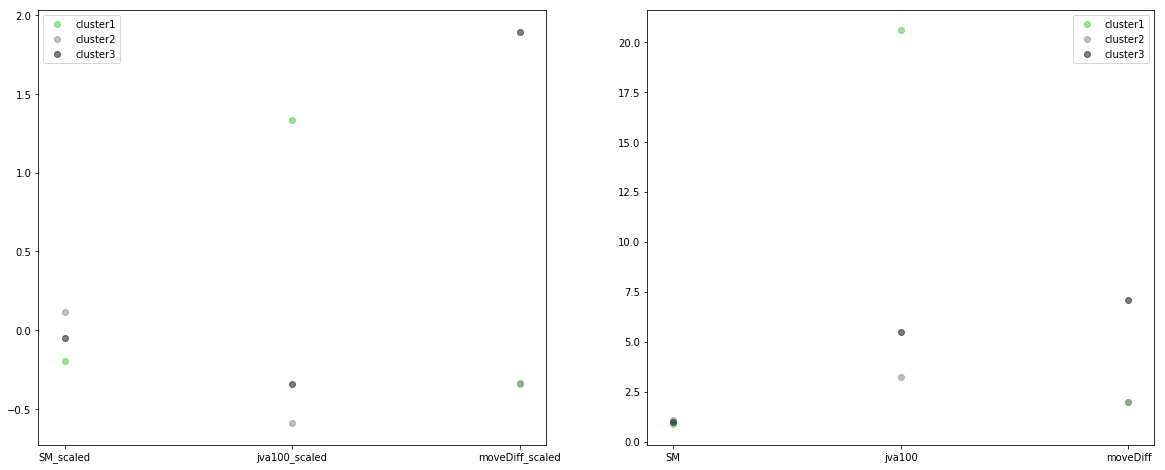

In [25]:
cluster.visualizeCluster(dfMaster_sm3, 3, ['SM_scaled','jva100_scaled','moveDiff_scaled'], ['SM','jva100','moveDiff'])

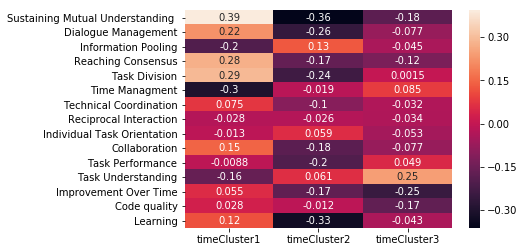

In [26]:
timeCluster_sm3 = cluster.timeCluster(dfMaster_sm3, 3)
sessions_sm3 = sessions.merge(timeCluster_sm3, on = 'Session', how = 'outer') #merge data frames for correlation
time_sm3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_sm3 = sessions_sm3.corr()
ax = sns.heatmap(correlations_sm3.loc[dependent][time_sm3], annot=True)

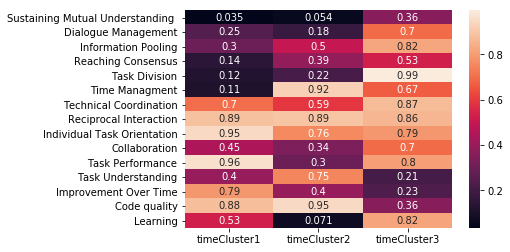

In [27]:
pvalues_sm3 = cluster.calculate_pvalues(sessions_sm3).astype(float)
ax = sns.heatmap(pvalues_sm3.loc[dependent][time_sm3], annot=True)

There is a significant correlation between 1) time spent in cluster 1 (highest jva100, lowest SM scaled value) and sustaining mutual understanding (p = 0.035).


**IDM+JVA+Kinect**

In [28]:
dfMaster_idm4, centroids_idm4 = cluster.makeCluster(dfMaster, 4, 11, ['IDM_scaled','jva100_scaled','moveDiff_scaled'])
dfMaster_idm3, centroids_idm3 = cluster.makeCluster(dfMaster, 3, 11, ['IDM_scaled','jva100_scaled','moveDiff_scaled'])

In [42]:
dfMaster_idm4.to_csv('../data_visualization/IDM_JVA_Kinect_4.csv')

----
K = 4

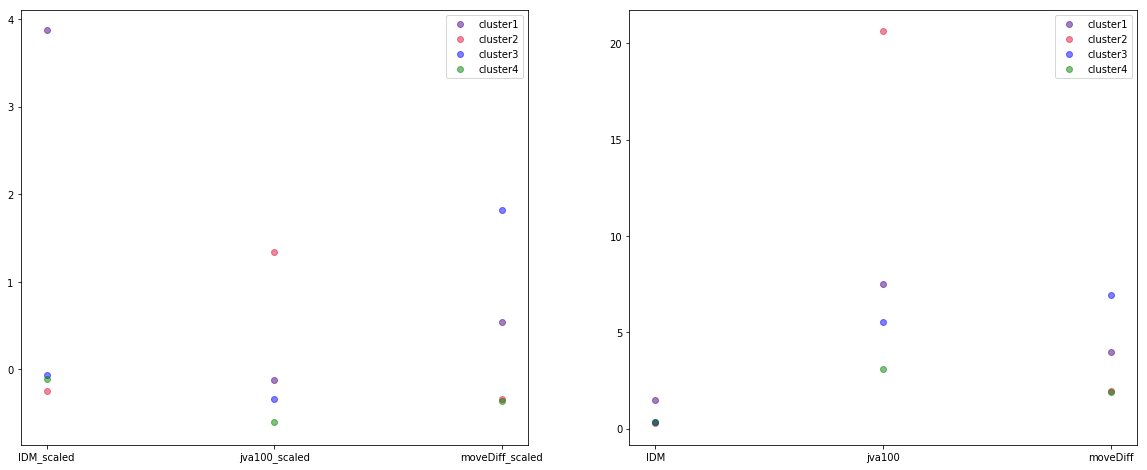

In [29]:
cluster.visualizeCluster(dfMaster_idm4, 4,['IDM_scaled','jva100_scaled','moveDiff_scaled'],['IDM','jva100','moveDiff'] )

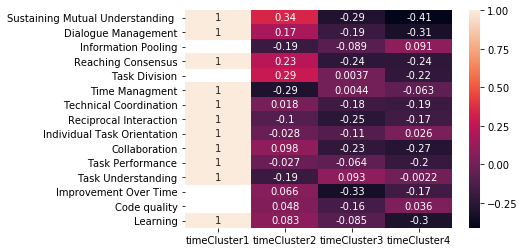

In [30]:
timeCluster_idm4 = cluster.timeCluster(dfMaster_idm4, 4)
sessions_idm4 = sessions.merge(timeCluster_idm4, on = 'Session', how = 'outer') #merge data frames for correlation
time_idm4 = ['timeCluster1','timeCluster2','timeCluster3','timeCluster4']

correlations_idm4 = sessions_idm4.corr()
ax = sns.heatmap(correlations_idm4.loc[dependent][time_idm4], annot=True)

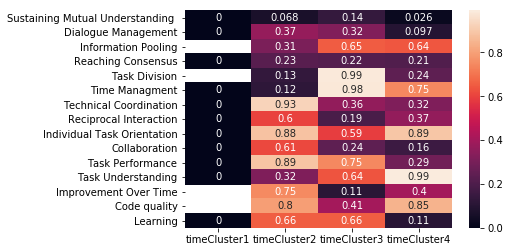

In [31]:
pvalues_idm4 = cluster.calculate_pvalues(sessions_idm4).astype(float)
ax = sns.heatmap(pvalues_idm4.loc[dependent][time_idm4], annot=True)

There is a significant correlations between 1) time spent in cluster 4 (lowest jva) and sustaining mutual understanding (p = 0.026). 

----
K = 3

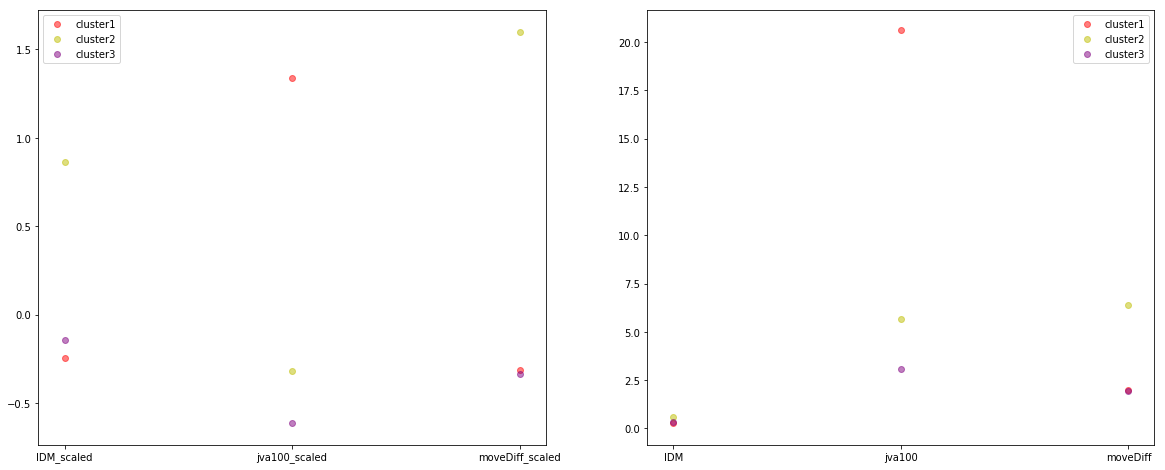

In [32]:
cluster.visualizeCluster(dfMaster_idm3, 3,['IDM_scaled','jva100_scaled','moveDiff_scaled'],['IDM','jva100','moveDiff'] )

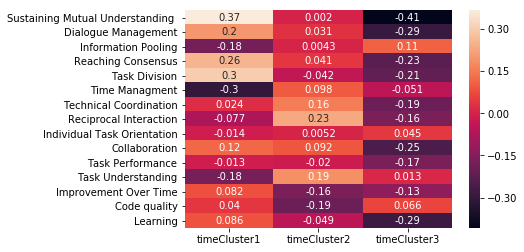

In [33]:
timeCluster_idm3 = cluster.timeCluster(dfMaster_idm3, 3)
sessions_idm3 = sessions.merge(timeCluster_idm3, on = 'Session', how = 'outer') #merge data frames for correlation
time_idm3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_idm3 = sessions_idm3.corr()
ax = sns.heatmap(correlations_idm3.loc[dependent][time_idm3], annot=True)

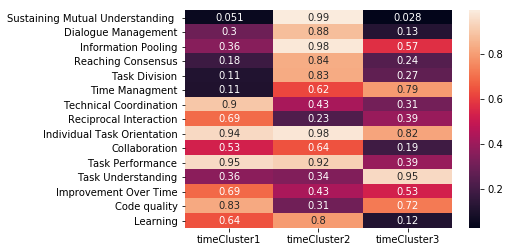

In [34]:
pvalues_idm3 = cluster.calculate_pvalues(sessions_idm3).astype(float)
ax = sns.heatmap(pvalues_idm3.loc[dependent][time_idm3], annot=True)

There is a significant correlation between 1) time spent in cluster 3 (lowest jva, least movement difference) and sustaining mutual understanding (p = 0.028). 